In [29]:
from torch import nn
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Calculate accuracy (a classification metric)
# to measure how many correct answer out of 100
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

I have two devices for training. One PC at home and one MacBook for coding out.

In [31]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

---

In [43]:
df = pd.read_csv('data/Comfort/data.csv')

In [42]:
import random
for i in range(600):
    rpm_max = random.uniform(0.15, 0.365316)
    gas = random.uniform(0.75, 1.0)
    brake = 0.0
    in_first_gear = 0.0
    in_overdrive = 1
    shift_status = 0.0
    jump_gears = 1
    new_jump = pd.DataFrame([[rpm_max, gas, brake, in_first_gear, in_overdrive, shift_status, jump_gears]], columns=df.columns)
    new_jump.to_csv('data/Comfort/data.csv', mode='a', header=False, index=False)
    

In [44]:
df.describe()

,rpm/max,gas,brake,in_first_gear,in_overdrive,shift_status,jump_gears
count,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000
mean,0.315781,0.748516,0.032114,0.037838,0.707027,0.351351,0.648649
std,0.176735,0.280003,0.133306,0.190907,0.455372,0.527194,0.477651
min,-0.012742,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.199518,0.754563,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.274285,0.844948,0.000000,0.000000,1.000000,0.000000,1.000000
75%,0.348913,0.935059,0.000000,0.000000,1.000000,1.000000,1.000000
max,0.882648,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000


### Showing **correlation** between features. To help us choose features

<Axes: >

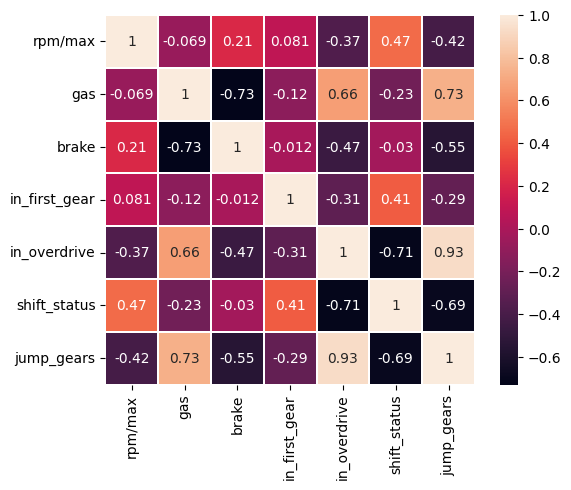

In [63]:
sns.heatmap(df.corr(), linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)

In [64]:
features = df[['rpm/max', 'gas', 'brake', 'in_first_gear', 'in_overdrive']].values
labels = df[['shift_status', 'jump_gears']].values

In [65]:
Xtrain, Xtest, yTrain, yTest = train_test_split(features, labels, shuffle=True, test_size=0.3)

---

## Create a **Neural Network** and output two results(shift or not, jump gears or not)

In [66]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 3)  # Output layer for shift status (0, 1, 2)
        self.fc6 = nn.Linear(128, 1)  # Output layer for jump gears or not (0 or 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        shift = self.fc5(x)  # Predicts shift status
        jump = self.fc6(x)  # Predicts whether to jump gears or not
        return shift, jump

In [67]:
model = Net().to(device)
shift_lossFn = nn.CrossEntropyLoss()  # For shift status (multi-class classification)
jump_lossFn = nn.BCEWithLogitsLoss() # For jump gears
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.002)

In [68]:
Xtrain = torch.from_numpy(Xtrain).to(torch.float).to(device)
Xtest= torch.from_numpy(Xtest).to(torch.float).to(device)
yTrain = torch.from_numpy(yTrain).to(torch.float).to(device)
yTest= torch.from_numpy(yTest).to(torch.float).to(device)

In [69]:
from tqdm.auto import tqdm

epochs = 25000

for epoch in tqdm(range(1, epochs+1)):
    model.train()
    
    shift_logit, jump_logit = model(Xtrain)
    
    shift_prob = torch.softmax(shift_logit, dim=1)
    shift_pred = torch.argmax(shift_prob, dim=1)
    shift_loss = shift_lossFn(shift_logit, yTrain[:, 0].long())
    shift_acc = accuracy_fn(y_true=yTrain[:, 0], y_pred=shift_pred)

    jump_prob = torch.sigmoid(jump_logit)
    jump_pred = torch.round(jump_prob).squeeze(dim=1)
    jump_loss = jump_lossFn(jump_logit.squeeze(dim=1), yTrain[:, 1])
    jump_acc = accuracy_fn(y_true=yTrain[:, 1], y_pred=jump_pred)

    optimizer.zero_grad()
    shift_loss.backward(retain_graph=True)
    jump_loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        shift_test_logit, jump_test_logit = model(Xtest)
        
        shift_test_prob = torch.softmax(shift_test_logit, dim=1)
        shift_test_pred = torch.argmax(shift_test_prob, dim=1)
        shift_test_loss = shift_lossFn(shift_test_logit, yTest[:, 0].long())
        shift_test_acc = accuracy_fn(y_true=yTest[:, 0], y_pred=shift_test_pred)

        jump_test_prob = torch.sigmoid(jump_test_logit)
        jump_test_pred = torch.round(jump_test_prob).squeeze(dim=1)
        jump_test_loss = jump_lossFn(jump_test_logit.squeeze(dim=1), yTest[:, 1])
        jump_test_acc = accuracy_fn(y_true=yTest[:, 1], y_pred=jump_test_pred)

    if epoch % 50 == 0:
        print(f"Epoch: {epoch}\nTrain shift loss: {shift_loss.item():.4f} | Train jump loss: {jump_loss.item():.4f} | Train shift acc: {shift_acc:.2f}% | Train jump acc: {jump_acc:.2f}%\nTest shift loss: {shift_test_loss.item():.4f} | Test jump loss: {jump_test_loss.item():.4f} | Test shift acc: {shift_test_acc:.2f}% | Test jump acc: {jump_test_acc:.2f}%")
    if epoch == epochs+1:
        if shift_test_loss > 0.6 or jump_test_loss > 0.6:
            print('WTF IS THIS SHIT MAN UR DATA SUCKS')


  0%|          | 0/25000 [00:00<?, ?it/s]

Epoch: 50
Train shift loss: 0.9954 | Train jump loss: 0.6433 | Train shift acc: 95.80% | Train jump acc: 92.48%
Test shift loss: 0.9907 | Test jump loss: 0.6412 | Test shift acc: 97.94% | Test jump acc: 93.81%
Epoch: 100
Train shift loss: 0.9148 | Train jump loss: 0.6184 | Train shift acc: 95.80% | Train jump acc: 92.48%
Test shift loss: 0.9073 | Test jump loss: 0.6154 | Test shift acc: 97.94% | Test jump acc: 93.81%
Epoch: 150
Train shift loss: 0.8396 | Train jump loss: 0.5943 | Train shift acc: 95.80% | Train jump acc: 92.48%
Test shift loss: 0.8293 | Test jump loss: 0.5905 | Test shift acc: 97.94% | Test jump acc: 93.81%
Epoch: 200
Train shift loss: 0.7682 | Train jump loss: 0.5706 | Train shift acc: 95.80% | Train jump acc: 92.48%
Test shift loss: 0.7550 | Test jump loss: 0.5659 | Test shift acc: 97.94% | Test jump acc: 93.81%
Epoch: 250
Train shift loss: 0.7000 | Train jump loss: 0.5469 | Train shift acc: 95.80% | Train jump acc: 92.48%
Test shift loss: 0.6840 | Test jump loss: 0.

In [70]:
from pathlib import Path

PATH = Path('MODELS')
PATH.mkdir(exist_ok=True, parents=True)

MODEL_PATH = PATH / 'first_comfort_model.pth'
print(f"Saving model to {MODEL_PATH}")
torch.save(model.state_dict(), MODEL_PATH)

Saving model to MODELS\first_comfort_model.pth


In [71]:

load_model = Net()
load_model.load_state_dict(torch.load('MODELS/first_comfort_model.pth', map_location=torch.device('cpu'))) # set map_location to CPU to ensure compatibility (despite from training device (CUDA, MPS))

<All keys matched successfully>

In [54]:
load_model.eval()
with torch.no_grad():
    shift_logit, jump_logit = load_model(torch.Tensor([[0.22, 0.95, 0.0, 0.0, 1.0]]))
    
    shift_prob = torch.softmax(shift_logit, dim=1)
    shift_pred = torch.argmax(shift_prob, dim=1)
    jump_prob = torch.sigmoid(jump_logit)
    jump_pred = torch.round(jump_prob).squeeze(dim=1)
    

In [55]:
shift_pred, jump_pred

(tensor([0]), tensor([1.]))

In [56]:
import random
import pandas as pd
df = pd.read_csv('data/Normal/data.csv')

for i in range(500):
    rpm_max = random.uniform(0.38, 0.58)
    gas = random.uniform(0.3, 0.48)
    brake = 0.0
    in_first_gear = 0
    in_overdrive = 0 if in_first_gear == 1 else random.randint(0, 1)
    shift_status = 2
    jump_gears = 0
    new_jump = pd.DataFrame([[rpm_max, gas, brake, in_first_gear, in_overdrive, shift_status, jump_gears]], columns=df.columns)
    new_jump.to_csv('data/Normal/data.csv', mode='a', header=False, index=False)

In [57]:
df

,rpm/max,gas,brake,in_first_gear,in_overdrive,shift_status,jump_gears
0,0.046508,0.086275,0.0,1.0,0,1.0,0
1,0.111514,0.078431,0.0,1.0,0,1.0,0
2,0.141863,0.152941,0.0,1.0,0,1.0,0
3,0.115843,0.168627,0.0,1.0,0,1.0,0
4,0.081191,0.176471,0.0,1.0,0,1.0,0
...,...,...,...,...,...,...,...
4239,0.230092,0.913538,0.0,0.0,1,0.0,1
4240,0.341387,0.949887,0.0,0.0,1,0.0,1
4241,0.340207,0.989957,0.0,0.0,1,0.0,1
4242,0.196550,0.860030,0.0,0.0,1,0.0,1


In [59]:
df = pd.read_csv('data/Comfort/data.csv')

In [60]:
df

,rpm/max,gas,brake,in_first_gear,in_overdrive,shift_status,jump_gears
0,0.092134,0.168627,0.0,1.0,0,1.0,0
1,0.186862,0.247059,0.0,1.0,0,1.0,0
2,0.143780,0.274510,0.0,1.0,0,1.0,0
3,0.097143,0.254902,0.0,1.0,0,1.0,0
4,0.158261,0.270588,0.0,1.0,0,2.0,0
...,...,...,...,...,...,...,...
920,0.283139,0.830569,0.0,0.0,1,0.0,1
921,0.343082,0.755623,0.0,0.0,1,0.0,1
922,0.262738,0.960830,0.0,0.0,1,0.0,1
923,0.254104,0.961665,0.0,0.0,1,0.0,1


In [61]:
df = df.loc[df['shift_status'] != 1.0]

In [62]:
df

,rpm/max,gas,brake,in_first_gear,in_overdrive,shift_status,jump_gears
4,0.158261,0.270588,0.0,1.0,0,2.0,0
9,0.155295,0.274510,0.0,0.0,0,2.0,0
17,0.132281,0.270588,0.0,0.0,0,2.0,0
30,0.120106,0.278431,0.0,0.0,0,2.0,0
35,0.082048,0.537255,0.0,0.0,1,0.0,0
...,...,...,...,...,...,...,...
920,0.283139,0.830569,0.0,0.0,1,0.0,1
921,0.343082,0.755623,0.0,0.0,1,0.0,1
922,0.262738,0.960830,0.0,0.0,1,0.0,1
923,0.254104,0.961665,0.0,0.0,1,0.0,1
